Capstone Project: DDoS Detection (Module 20)
===============================
This notebook is part of the Capstone Project for the course Emeritus UC Berkeley Professional Certificate in Machine Learning and Artificial Intelligence. The project aims to build a machine learning model to detect Distributed Denial of Service (DDoS) attacks in network traffic data using the CTU-13 dataset. This notebook will focus on the code implementation. The final report will include more detailed explanations, visualizations and citations. A detailed log of the code execution can be found in the [analysis log](./logs/analysis.log).



### Section 1 Import Libraries, Implement Logging & Set Global Variables
---

In [13]:
# ---------------------------------------------------------------------
# Section 1 Import Libraries, Implement Logging & Set Global Variables
# ---------------------------------------------------------------------
import logging
import os
import io
import time
import platform

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, auc
)

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Global variables
LOG_FOLDER = "logs"
LOG_FILENAME = "analysis.log"
PLOTS_FOLDER = "plots"
DATA_FOLDER = "data"
TEST_SIZE = 0.2
RANDOM_STATE = 42

# A helper to clear the console
def clear_console():
    """
    Clears the console/terminal in a cross-platform way.
    Works on windows (cls) or *nix (clear).
    Might not affect some ides (e.g., pycharm) or jupyter notebooks.
    """
    if platform.system().lower().startswith('win'):
        os.system('cls')
    else:
        os.system('clear')

# Logging + print function
def log_and_print(message, log_obj, level='info'):
    """
    A small utility to log and also print the same message to the console.
    This ensures that what's written to the log is also displayed in the console.
    Avoids overshadowing 'msg' or 'logger' from outer scope.
    """
    if level == 'info':
        log_obj.info(message)
    elif level == 'warning':
        log_obj.warning(message)
    elif level == 'error':
        log_obj.error(message)
    print(message)

# Clear console each run
clear_console()

# Ensure logs folder exists
os.makedirs(LOG_FOLDER, exist_ok=True)

# Configure the logger
main_logger = logging.getLogger(__name__)
main_logger.setLevel(logging.INFO)

# Path for the log file
log_path = os.path.join(LOG_FOLDER, LOG_FILENAME)

# Delete existing log file if it exists
if os.path.exists(log_path):
    os.remove(log_path)

# Remove existing handlers (if any) to avoid duplicates on re-run
main_logger.handlers.clear()

# File handler (captures all info and above)
file_handler = logging.FileHandler(log_path)
file_handler.setLevel(logging.INFO)

# Define logging format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

# Add only the file handler, no console handler
main_logger.addHandler(file_handler)

# Test: write an info message to file (and print to console)
log_and_print("Section 1 logging setup, import libraries, & global variables\n", main_logger, level='info')

Section 1 logging setup, import libraries, & global variables



### Section 2 Load & Explore Data
---

In [14]:
# ---------------------------------------------------------------------
# Section 2 Load & Explore Data
# ---------------------------------------------------------------------
log_and_print("\n\nSECTION 2: LOAD & EXPLORE DATA\n", main_logger, level='info')

# Use DATA_FOLDER for consistency
file_name = "11-Rbot-20110818-2.binetflow.csv"
file_path = os.path.join(DATA_FOLDER, file_name)

try:
    df = pd.read_csv(file_path)
    loaded_msg = f"Successfully loaded DataFrame with shape: {df.shape}"
    log_and_print(loaded_msg, main_logger, level='info')
except FileNotFoundError:
    error_msg = "File not found. Please check the path."
    log_and_print(error_msg, main_logger, level='error')
    raise

# Display a sample of the DataFrame
log_and_print("Sample rows of the DataFrame:", main_logger, level='info')
df_head_markdown = df.head().to_markdown()
log_and_print(f"\n{df_head_markdown}\n", main_logger, level='info')

# DataFrame info
log_and_print("Data types:", main_logger, level='info')

buf = io.StringIO()
df.info(buf=buf)
info_str = buf.getvalue()

log_and_print(f"\n```\n{info_str}\n```", main_logger, level='info')



SECTION 2: LOAD & EXPLORE DATA

Successfully loaded DataFrame with shape: (107251, 15)
Sample rows of the DataFrame:

|    | StartTime                  |     Dur | Proto   | SrcAddr       |   Sport | Dir   | DstAddr       |   Dport | State   |   sTos |   dTos |   TotPkts |   TotBytes |   SrcBytes | Label                           |
|---:|:---------------------------|--------:|:--------|:--------------|--------:|:------|:--------------|--------:|:--------|-------:|-------:|----------:|-----------:|-----------:|:--------------------------------|
|  0 | 2011/08/18 15:40:53.826372 | 2.98325 | tcp     | 76.76.172.248 |   63577 | ->    | 147.32.84.229 |   13363 | SR_SA   |      0 |      0 |         3 |        184 |        122 | flow=Background-TCP-Established |
|  1 | 2011/08/18 15:40:55.435494 | 2.90603 | tcp     | 76.76.172.248 |   63580 | ->    | 147.32.84.229 |     443 | SR_SA   |      0 |      0 |         3 |        184 |        122 | flow=Background-TCP-Established |
|  2 | 2011/08/1

### Section 3 Basic Data Cleaning & Feature Engineering
---

In [15]:
# ---------------------------------------------------------------------
# Section 3 Basic Data Cleaning & Feature Engineering
# ---------------------------------------------------------------------
log_and_print("\n\nSECTION 3: BASIC DATA CLEANING & FEATURE ENGINEERING\n", main_logger, level='info')

# 1. Remove rows containing 'Background'
if 'Label' in df.columns:
    df = df[~df['Label'].str.contains('Background', case=False, na=False)]
    df['Botnet'] = df['Label'].apply(lambda x: 1 if 'botnet' in str(x).lower() else 0)
    df.drop(columns=['Label'], inplace=True)
else:
    warning_msg = "No 'Label' column found. Modify label handling as appropriate."
    log_and_print(warning_msg, main_logger, level='warning')

# 4. Drop sTos, dTos, StartTime
cols_to_remove = ['sTos', 'dTos', 'StartTime']
for col in cols_to_remove:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

def safe_divide(num, denom):
    return num / denom if denom != 0 else 0

# Create BytesPerSecond & PktsPerSecond
df['BytesPerSecond'] = df.apply(lambda row: safe_divide(row['TotBytes'], row['Dur']), axis=1)
df['PktsPerSecond'] = df.apply(lambda row: safe_divide(row['TotPkts'], row['Dur']), axis=1)

def address_entropy(addr):
    addr_str = str(addr)
    c_count = Counter(addr_str)
    total_chars = len(addr_str)
    if total_chars < 2:
        return 0
    e_value = 0
    for char_count in c_count.values():
        p = char_count / total_chars
        e_value -= p * math.log2(p)
    return e_value

df['SrcAddrEntropy'] = df['SrcAddr'].apply(address_entropy)
df['DstAddrEntropy'] = df['DstAddr'].apply(address_entropy)

def get_port_range(x):
    # Instead of a bare except, catch ValueError, TypeError
    try:
        port = int(x)
    except (ValueError, TypeError):
        return 'Unknown'
    if 0 <= port <= 1023:
        return 'WellKnown'
    elif 1024 <= port <= 49151:
        return 'Registered'
    elif 49152 <= port <= 65535:
        return 'Ephemeral'
    else:
        return 'Unknown'

if 'Sport' in df.columns:
    df['SportRange'] = df['Sport'].apply(get_port_range)
    df.drop(columns=['Sport'], inplace=True)

if 'Dport' in df.columns:
    df['DportRange'] = df['Dport'].apply(get_port_range)
    df.drop(columns=['Dport'], inplace=True)

main_features = [
    'Dur', 'Proto', 'Dir', 'State',
    'SrcAddr', 'DstAddr',
    'SportRange', 'DportRange',
    'TotPkts', 'TotBytes', 'SrcBytes',
    'BytesPerSecond', 'PktsPerSecond',
    'SrcAddrEntropy', 'DstAddrEntropy',
    'Botnet'
]

df = df[[col for col in main_features if col in df.columns]]

if 'Botnet' in df.columns:
    y = df['Botnet']
    X = df.drop('Botnet', axis=1)
    shape_msg = f"Feature matrix shape: {X.shape}, Target vector shape: {y.shape}"
    log_and_print(shape_msg, main_logger, level='info')
else:
    error_msg = "No 'Botnet' column identified for classification. Exiting."
    log_and_print(error_msg, main_logger, level='error')
    raise ValueError(error_msg)

for ip_col in ['SrcAddr', 'DstAddr']:
    if ip_col in X.columns:
        X.drop(columns=[ip_col], inplace=True)

categorical_cols = ['Proto', 'Dir', 'State', 'SportRange', 'DportRange']
for cat_col in categorical_cols:
    if cat_col in X.columns and X[cat_col].dtype == 'object':
        X[cat_col] = X[cat_col].astype('category').cat.codes

log_and_print("Showing the first few rows of the engineered DataFrame:", main_logger, level='info')

df_head_markdown = df.head().to_markdown()
log_and_print(f"\n\n{df_head_markdown}\n", main_logger, level='info')

buf = io.StringIO()
df.info(buf=buf)
info_str = buf.getvalue()
log_and_print(f"\n\n{info_str}\n", main_logger, level='info')



SECTION 3: BASIC DATA CLEANING & FEATURE ENGINEERING

Feature matrix shape: (10882, 15), Target vector shape: (10882,)
Showing the first few rows of the engineered DataFrame:


|     |     Dur | Proto   | Dir   | State   | SrcAddr       | DstAddr        | SportRange   | DportRange   |   TotPkts |   TotBytes |   SrcBytes |   BytesPerSecond |   PktsPerSecond |   SrcAddrEntropy |   DstAddrEntropy |   Botnet |
|----:|--------:|:--------|:------|:--------|:--------------|:---------------|:-------------|:-------------|----------:|-----------:|-----------:|-----------------:|----------------:|-----------------:|-----------------:|---------:|
|  40 | 969.979 | tcp     | <?>   | PA_RPA  | 147.32.84.164 | 64.12.68.227   | Ephemeral    | WellKnown    |        53 |       4279 |       1791 |          4.41144 |       0.0546404 |          2.81507 |          2.62581 |        0 |
|  41 | 960.129 | tcp     | <?>   | PA_A    | 147.32.84.164 | 64.12.73.134   | Registered   | WellKnown    |        38 |  

### Section 4 Visualizations
---



SECTION 4: VISUALIZATIONS

Creating basic visualizations...
Bar/Pie chart figure saved to plots/botnet_distribution.png


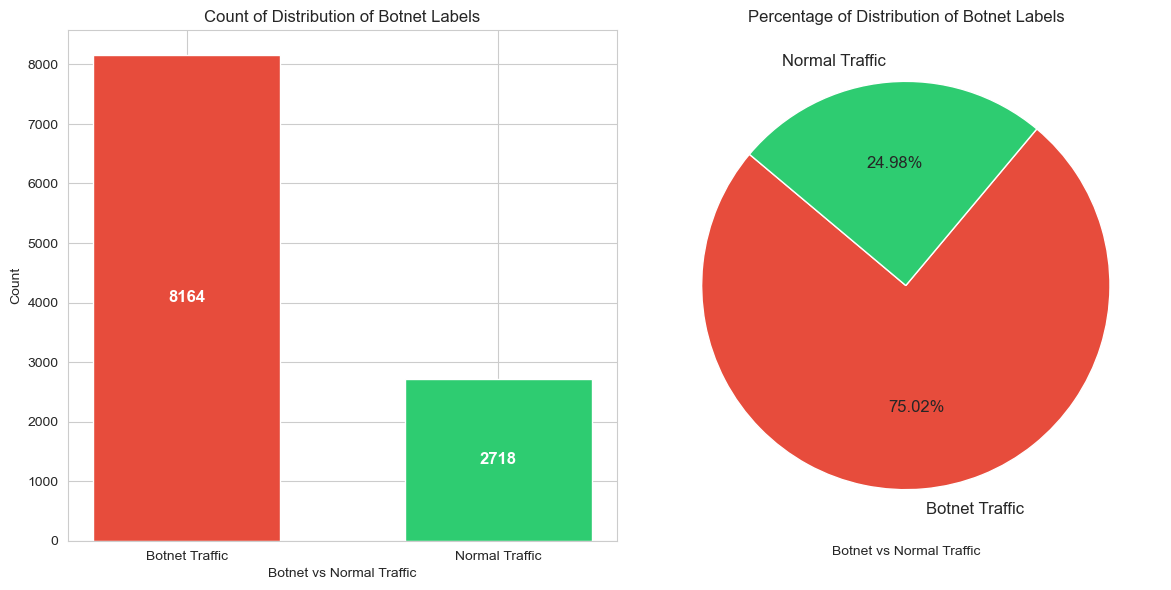

Correlation heatmap saved to plots/correlation_heatmap.png


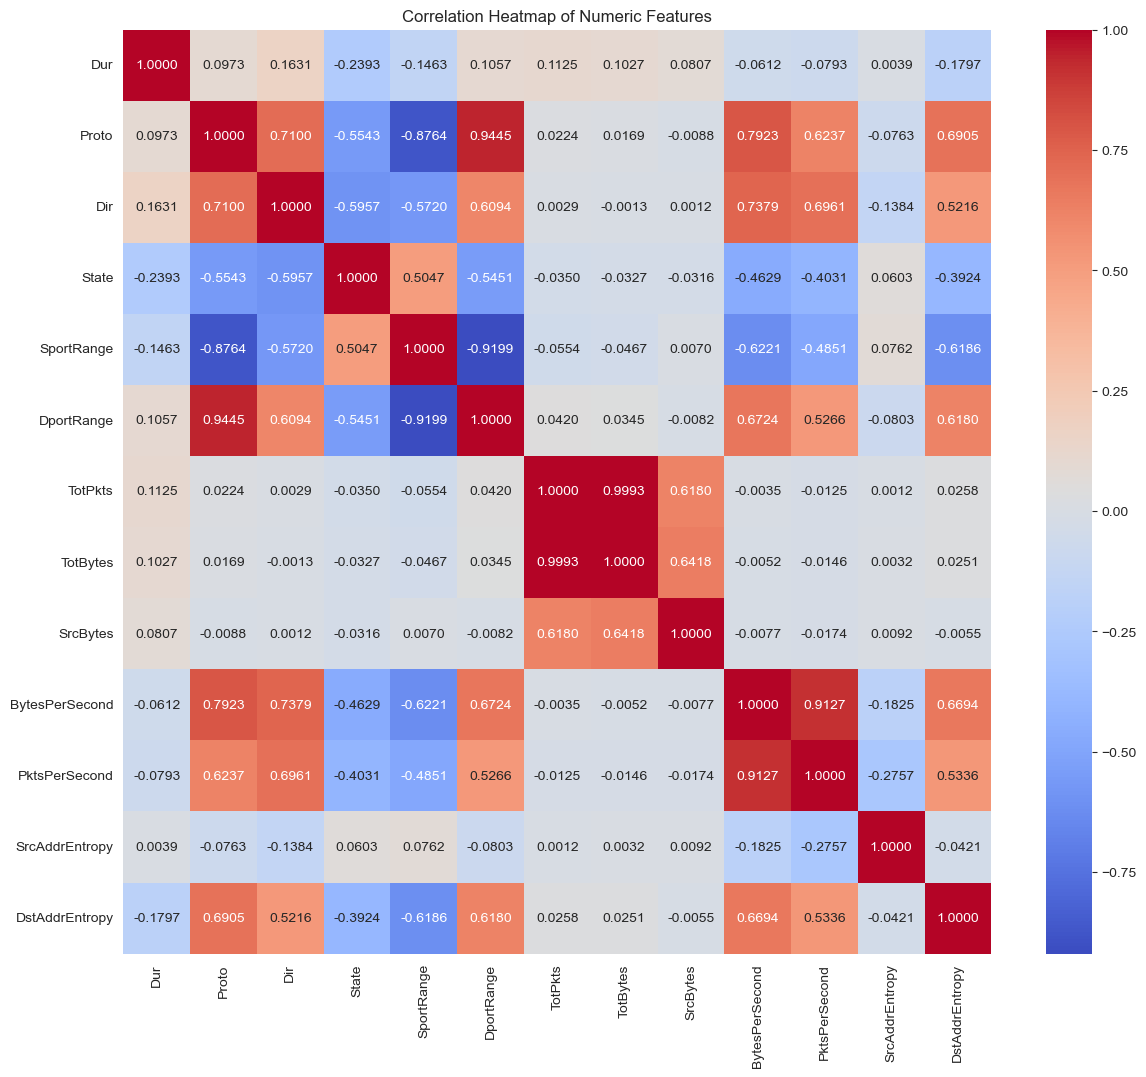

Creating additional distribution plots for numeric & categorical features...
Count plot saved to plots/countplot_sortrange_botnet.png


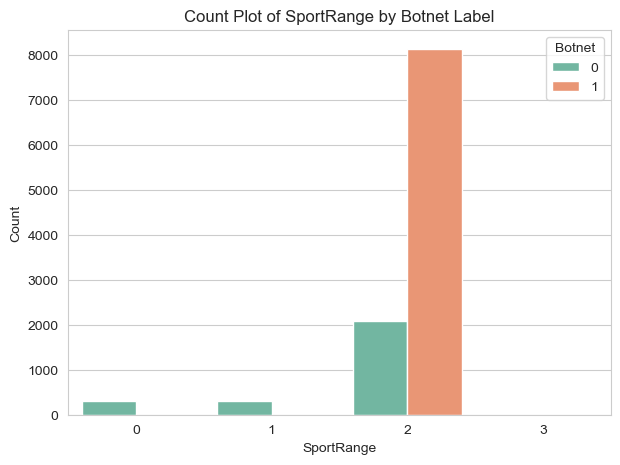

Box plot saved to plots/boxplot_pktspersec_botnet.png


/var/folders/8v/pk6lgrss0g53g9068c5f_v880000gn/T/ipykernel_96760/1463836541.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y, y=X['PktsPerSecond'], palette='Set3')


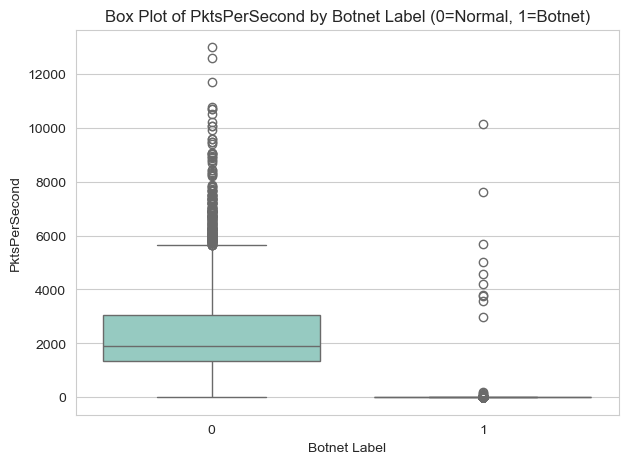

/var/folders/8v/pk6lgrss0g53g9068c5f_v880000gn/T/ipykernel_96760/1463836541.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='Botnet', y='BytesPerSecond', data=df_plot, size=3, jitter=True, palette='Set1')


Strip plot saved to plots/stripplot_bytespersec_botnet.png


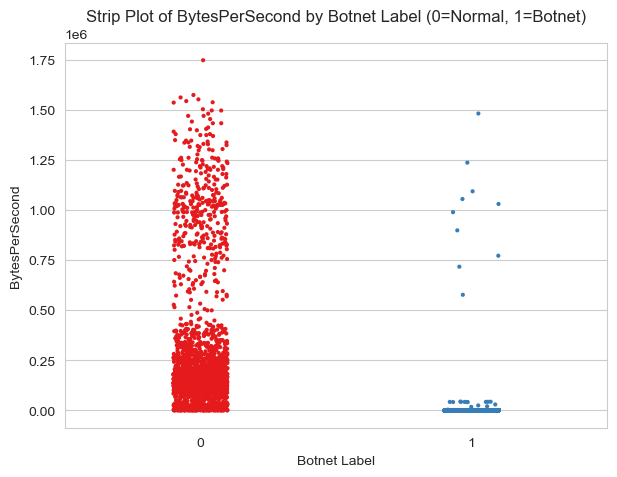

In [16]:
# ---------------------------------------------------------------------
# Section 4 Visualizations
# ---------------------------------------------------------------------
log_and_print("\n\nSECTION 4: VISUALIZATIONS\n", main_logger, level='info')

log_and_print("Creating basic visualizations...", main_logger, level='info')

os.makedirs(PLOTS_FOLDER, exist_ok=True)

# 1) BAR & PIE CHART OF BOTNET VS NORMAL
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

counts = y.value_counts()
labels_map = {0: "Normal Traffic", 1: "Botnet Traffic"}
plot_labels = [labels_map.get(idx, str(idx)) for idx in counts.index]
plot_values = counts.values

color_map = {
    "Normal Traffic": "#2ecc71",
    "Botnet Traffic": "#e74c3c"
}
bar_colors = [color_map[label] for label in plot_labels]

axes[0].bar(plot_labels, plot_values, color=bar_colors, width=0.6)

for i, v in enumerate(plot_values):
    axes[0].text(
        i,
        v / 2,
        str(v),
        ha='center',
        va='center',
        color='white',
        fontweight='bold',
        fontsize=12
    )

axes[0].set_title("Count of Distribution of Botnet Labels")
axes[0].set_xlabel("Botnet vs Normal Traffic")
axes[0].set_ylabel("Count")

axes[1].pie(
    plot_values,
    labels=plot_labels,
    colors=bar_colors,
    autopct='%1.2f%%',
    startangle=140,
    textprops={'fontsize': 12}
)
axes[1].set_title("Percentage of Distribution of Botnet Labels")
axes[1].set_xlabel("Botnet vs Normal Traffic")

plt.tight_layout()

bar_pie_filename = os.path.join(PLOTS_FOLDER, "botnet_distribution.png")
plt.savefig(bar_pie_filename, dpi=300)
log_and_print(f"Bar/Pie chart figure saved to {bar_pie_filename}", main_logger, level='info')
plt.show()

# 2) CORRELATION HEATMAP (NUMERIC FEATURES)
X_numeric = X.select_dtypes(include=[np.number])
if (X_numeric.shape[0] > 1) and (X_numeric.shape[1] > 1):
    correlation_matrix = X_numeric.corr()
    plt.figure(figsize=(14, 12))
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".4f")
    plt.title("Correlation Heatmap of Numeric Features")

    heatmap_filename = os.path.join(PLOTS_FOLDER, "correlation_heatmap.png")
    plt.savefig(heatmap_filename, dpi=300)

    log_and_print(f"Correlation heatmap saved to {heatmap_filename}", main_logger, level='info')
    plt.show()
else:
    msg_warn = (
        f"Skipping correlation heatmap. "
        f"X_numeric has shape {X_numeric.shape}, needs ≥2 rows & 2 columns."
    )
    log_and_print("WARNING: " + msg_warn, main_logger, level='warning')

# 3) Additional categorical & distribution plots
log_and_print("Creating additional distribution plots for numeric & categorical features...", main_logger, level='info')

# 3A) COUNT PLOT: SportRange vs. Botnet
if 'SportRange' in X.columns:
    plt.figure(figsize=(7,5))
    df_count = pd.DataFrame({'SportRange': X['SportRange'], 'Botnet': y})
    sns.countplot(data=df_count, x='SportRange', hue='Botnet', palette='Set2')
    plt.title("Count Plot of SportRange by Botnet Label")
    plt.xlabel("SportRange")
    plt.ylabel("Count")

    countplot_filename = os.path.join(PLOTS_FOLDER, "countplot_sortrange_botnet.png")
    plt.savefig(countplot_filename, dpi=300)
    log_and_print(f"Count plot saved to {countplot_filename}", main_logger, level='info')
    plt.show()

# 3B) BOX PLOT: PktsPerSecond by Botnet
plt.figure(figsize=(7, 5))
sns.boxplot(x=y, y=X['PktsPerSecond'], palette='Set3')
plt.title("Box Plot of PktsPerSecond by Botnet Label (0=Normal, 1=Botnet)")
plt.xlabel("Botnet Label")
plt.ylabel("PktsPerSecond")

boxplot_filename = os.path.join(PLOTS_FOLDER, "boxplot_pktspersec_botnet.png")
plt.savefig(boxplot_filename, dpi=300)
log_and_print(f"Box plot saved to {boxplot_filename}", main_logger, level='info')
plt.show()

# 3C) Strip plot of BytesPerSecond vs. Botnet
plt.figure(figsize=(7, 5))
df_plot = pd.DataFrame({'BytesPerSecond': X['BytesPerSecond'], 'Botnet': y})
sns.stripplot(x='Botnet', y='BytesPerSecond', data=df_plot, size=3, jitter=True, palette='Set1')
plt.title("Strip Plot of BytesPerSecond by Botnet Label (0=Normal, 1=Botnet)")
plt.xlabel("Botnet Label")
plt.ylabel("BytesPerSecond")

stripplot_filename = os.path.join(PLOTS_FOLDER, "stripplot_bytespersec_botnet.png")
plt.savefig(stripplot_filename, dpi=300)
log_and_print(f"Strip plot saved to {stripplot_filename}", main_logger, level='info')
plt.show()

### Section 5 Train-Test Split and Multi-Model Pipeline
---



SECTION 5: TRAIN-TEST SPLIT AND MULTI-MODEL PIPELINE

Splitting dataset into train and test sets...
Train set shape: (8705, 13), Test set shape: (2177, 13)
MODEL: RandomForest with GridSearchCV

Fitting RandomForest model with GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
RandomForest -> Training time: 2.14 seconds

Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       544
           1       1.00      1.00      1.00      1633

    accuracy                           1.00      2177
   macro avg       1.00      1.00      1.00      2177
weighted avg       1.00      1.00      1.00      2177

RandomForest -> Best Params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}
RandomForest -> Best CV Score (F1): 0.9992
RandomForest -> Test Accuracy: 0.9986
RandomForest -> Test Precision: 0.9988
RandomForest -> Test Recall:

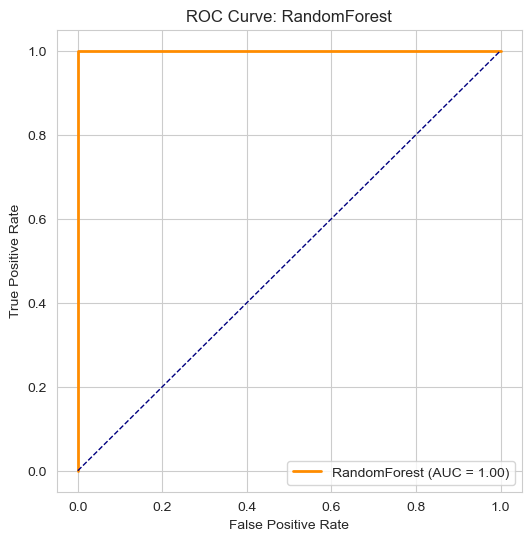

Confusion matrix saved to plots/confusion_matrix_RandomForest.png


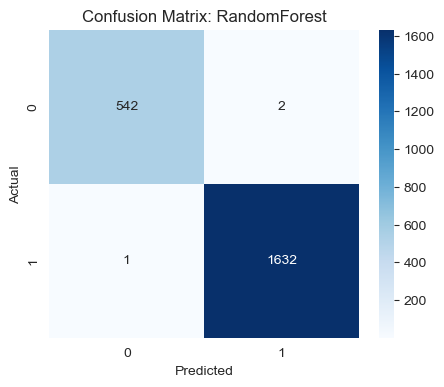

Top 10 features bar chart saved to plots/top10_features_RandomForest.png


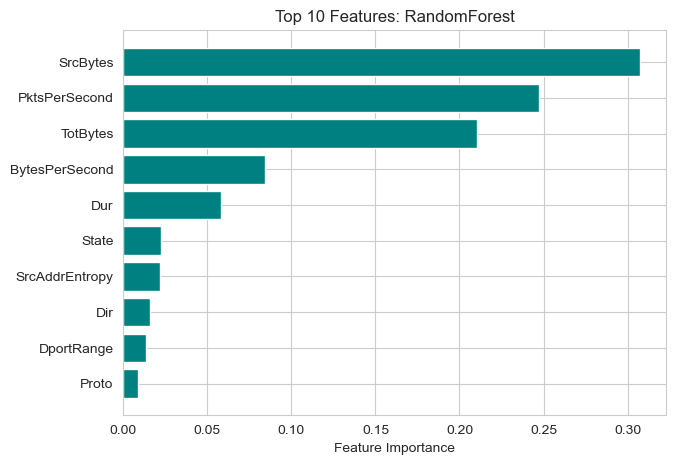


Starting GridSearch for DecisionTree...
MODEL: DecisionTree with GridSearchCV

Fitting DecisionTree model with GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
DecisionTree -> Training time: 0.09 seconds

Classification Report for DecisionTree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       544
           1       1.00      1.00      1.00      1633

    accuracy                           1.00      2177
   macro avg       1.00      1.00      1.00      2177
weighted avg       1.00      1.00      1.00      2177

DecisionTree -> Best Params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
DecisionTree -> Best CV Score (F1): 0.9991
DecisionTree -> Test Accuracy: 0.9991
DecisionTree -> Test Precision: 0.9988
DecisionTree -> Test Recall: 1.0000
DecisionTree -> Test F1 Score: 0.9994
DecisionTree -> Test ROC AUC: 0.9982

DecisionTree -> Top 10 features (feature_importances_):
  

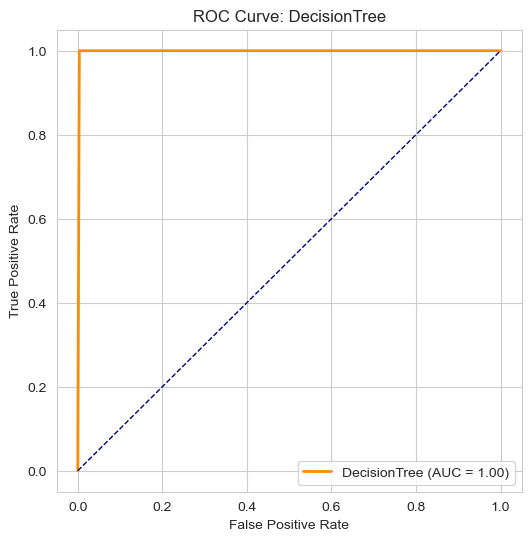

Confusion matrix saved to plots/confusion_matrix_DecisionTree.png


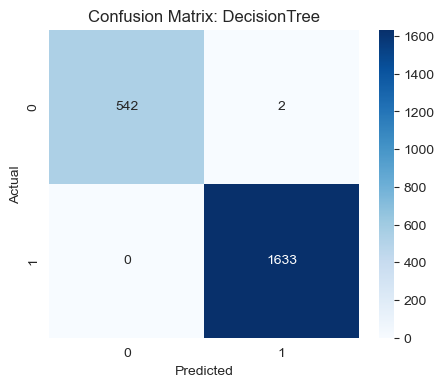

Top 10 features bar chart saved to plots/top10_features_DecisionTree.png


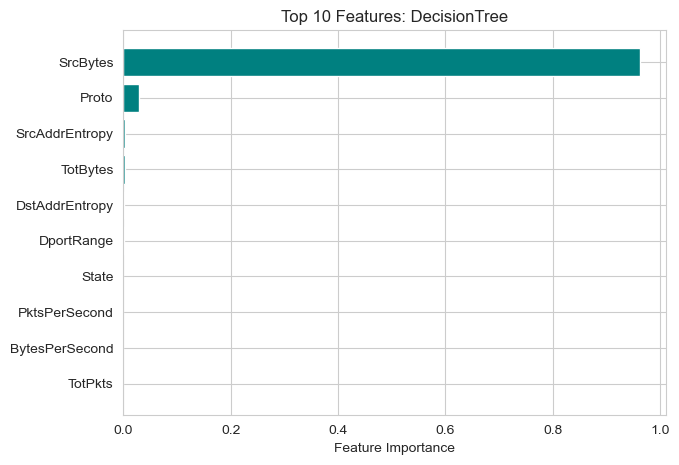


Starting GridSearch for NaiveBayes...
MODEL: NaiveBayes with GridSearchCV

Fitting NaiveBayes model with GridSearchCV...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
NaiveBayes -> Training time: 0.04 seconds

Classification Report for NaiveBayes:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       544
           1       0.98      1.00      0.99      1633

    accuracy                           0.98      2177
   macro avg       0.99      0.97      0.97      2177
weighted avg       0.98      0.98      0.98      2177

NaiveBayes -> Best Params: {'clf__var_smoothing': 1e-09}
NaiveBayes -> Best CV Score (F1): 0.9865
NaiveBayes -> Test Accuracy: 0.9816
NaiveBayes -> Test Precision: 0.9778
NaiveBayes -> Test Recall: 0.9982
NaiveBayes -> Test F1 Score: 0.9879
NaiveBayes -> Test ROC AUC: 0.9963

ROC curve saved to plots/roc_NaiveBayes.png


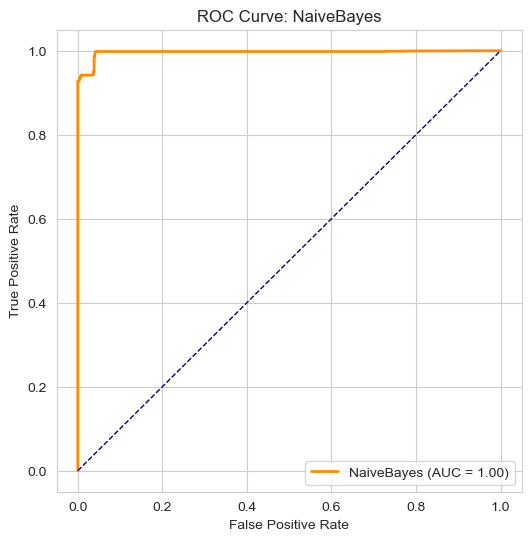

Confusion matrix saved to plots/confusion_matrix_NaiveBayes.png


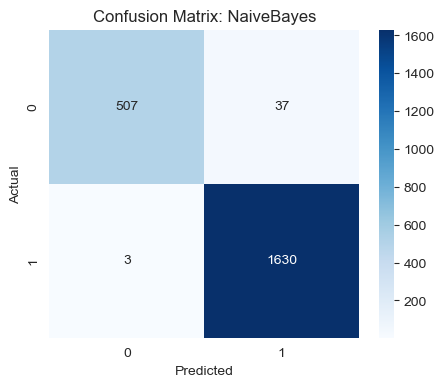


Starting GridSearch for KNN...
MODEL: KNN with GridSearchCV

Fitting KNN model with GridSearchCV...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
KNN -> Training time: 0.20 seconds

Classification Report for KNN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       544
           1       1.00      1.00      1.00      1633

    accuracy                           1.00      2177
   macro avg       1.00      1.00      1.00      2177
weighted avg       1.00      1.00      1.00      2177

KNN -> Best Params: {'clf__n_neighbors': 5, 'clf__weights': 'distance'}
KNN -> Best CV Score (F1): 0.9988
KNN -> Test Accuracy: 0.9991
KNN -> Test Precision: 1.0000
KNN -> Test Recall: 0.9988
KNN -> Test F1 Score: 0.9994
KNN -> Test ROC AUC: 1.0000

ROC curve saved to plots/roc_KNN.png


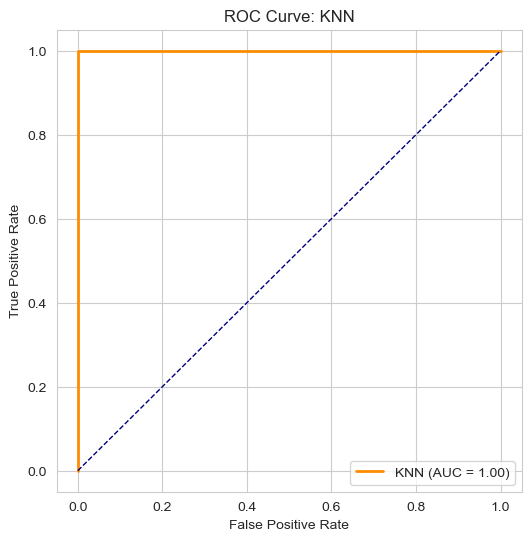

Confusion matrix saved to plots/confusion_matrix_KNN.png


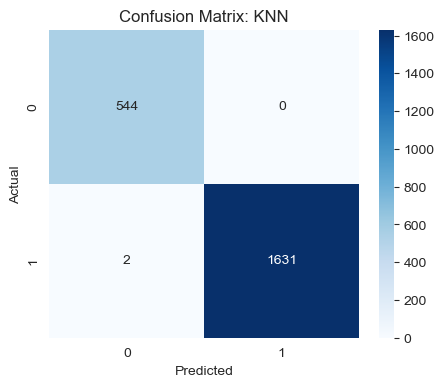


Starting GridSearch for SVM...
MODEL: SVM with GridSearchCV

Fitting SVM model with GridSearchCV...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
SVM -> Training time: 3.75 seconds

Classification Report for SVM:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       544
           1       1.00      1.00      1.00      1633

    accuracy                           1.00      2177
   macro avg       1.00      0.99      1.00      2177
weighted avg       1.00      1.00      1.00      2177

SVM -> Best Params: {'clf__C': 10.0, 'clf__kernel': 'rbf'}
SVM -> Best CV Score (F1): 0.9953
SVM -> Test Accuracy: 0.9963
SVM -> Test Precision: 0.9957
SVM -> Test Recall: 0.9994
SVM -> Test F1 Score: 0.9976
SVM -> Test ROC AUC: 0.9999

ROC curve saved to plots/roc_SVM.png


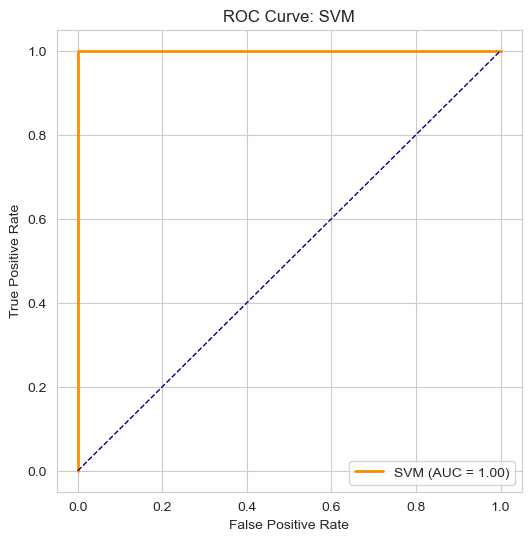

Confusion matrix saved to plots/confusion_matrix_SVM.png


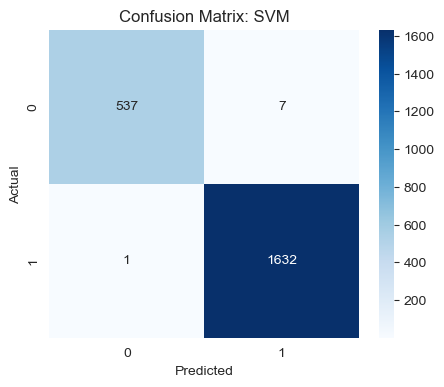


Starting GridSearch for LogisticRegression...
MODEL: LogisticRegression with GridSearchCV

Fitting LogisticRegression model with GridSearchCV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/mwstout/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mwstout/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mwstout/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mwstout/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mwstout/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mwstout/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235

LogisticRegression -> Training time: 21.13 seconds

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       544
           1       0.99      1.00      0.99      1633

    accuracy                           0.99      2177
   macro avg       0.99      0.98      0.99      2177
weighted avg       0.99      0.99      0.99      2177

LogisticRegression -> Best Params: {'clf__C': 10, 'clf__penalty': 'l1'}
LogisticRegression -> Best CV Score (F1): 0.9917
LogisticRegression -> Test Accuracy: 0.9890
LogisticRegression -> Test Precision: 0.9867
LogisticRegression -> Test Recall: 0.9988
LogisticRegression -> Test F1 Score: 0.9927
LogisticRegression -> Test ROC AUC: 0.9997

LogisticRegression -> Top 10 features (coef_):
  SrcBytes: 25.0571
  PktsPerSecond: -12.1941
  TotPkts: -8.7719
  BytesPerSecond: 6.4818
  TotBytes: 5.5126
  SrcAddrEntropy: 1.6464
  Dir: -1.6446
  SportRange: 1.3630
  State: 0.8161
  

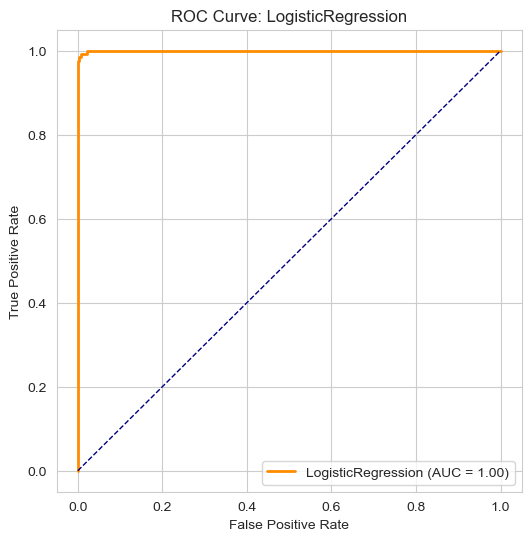

Confusion matrix saved to plots/confusion_matrix_LogisticRegression.png


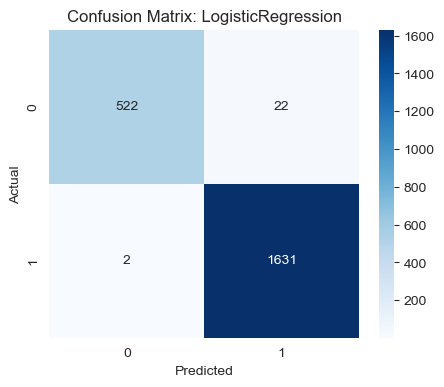

Top 10 features bar chart saved to plots/top10_features_LogisticRegression.png


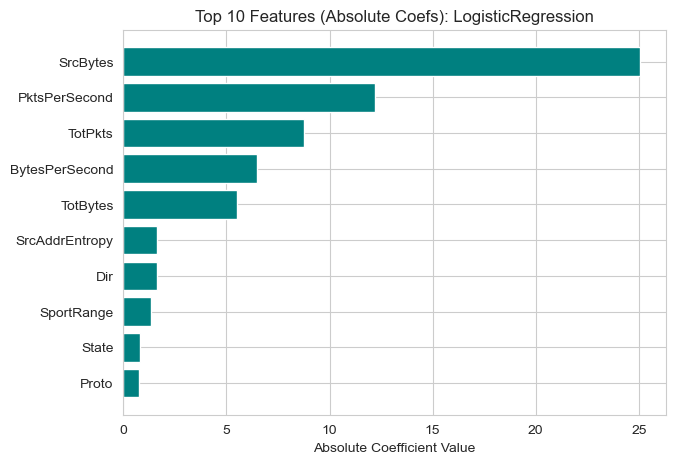


Starting GridSearch for GradientBoosting...
MODEL: GradientBoosting with GridSearchCV

Fitting GradientBoosting model with GridSearchCV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
GradientBoosting -> Training time: 1.37 seconds

Classification Report for GradientBoosting:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       544
           1       1.00      1.00      1.00      1633

    accuracy                           1.00      2177
   macro avg       1.00      1.00      1.00      2177
weighted avg       1.00      1.00      1.00      2177

GradientBoosting -> Best Params: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 100}
GradientBoosting -> Best CV Score (F1): 0.9992
GradientBoosting -> Test Accuracy: 0.9986
GradientBoosting -> Test Precision: 0.9988
GradientBoosting -> Test Recall: 0.9994
GradientBoosting -> Test F1 Score: 0.9991
GradientBoosting -> Test ROC AUC: 1.0000

GradientBoosting

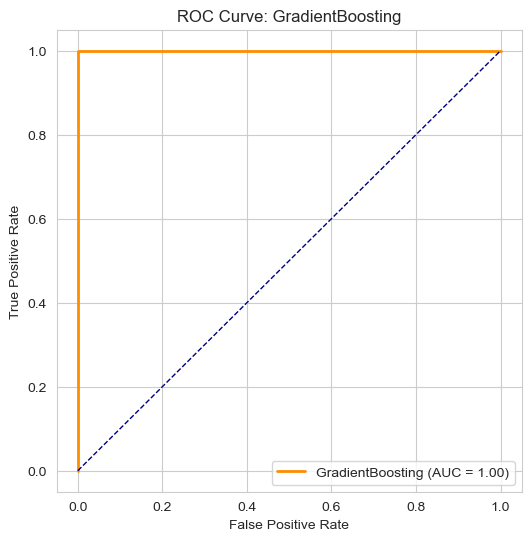

Confusion matrix saved to plots/confusion_matrix_GradientBoosting.png


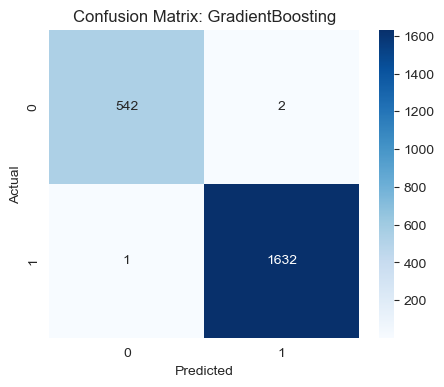

Top 10 features bar chart saved to plots/top10_features_GradientBoosting.png


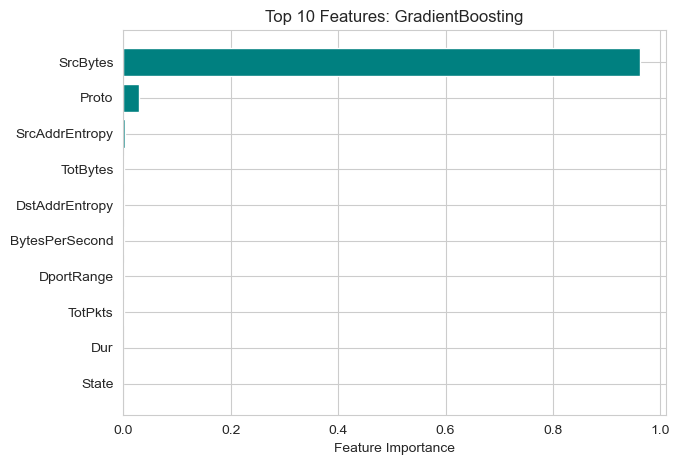


All GridSearches complete. Summary of results:
Model: RandomForest
  Best Params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}
  Train Time (s): 2.14
  CV F1: 0.9992
  Test Accuracy: 0.9986
  Test Precision: 0.9988
  Test Recall: 0.9994
  Test F1: 0.9991
  Specificity: 0.9963
  Test ROC AUC: 0.9999977486401787
  Log Loss: 0.001993584324529658
  mAP: 0.9999992509237047
  Confusion Matrix:

[[ 542    2]
 [   1 1632]]

Model: DecisionTree
  Best Params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
  Train Time (s): 0.09
  CV F1: 0.9991
  Test Accuracy: 0.9991
  Test Precision: 0.9988
  Test Recall: 1.0000
  Test F1: 0.9994
  Specificity: 0.9963
  Test ROC AUC: 0.9981617647058824
  Log Loss: 0.03311314045853688
  mAP: 0.998776758409786
  Confusion Matrix:

[[ 542    2]
 [   0 1633]]

Model: NaiveBayes
  Best Params: {'clf__var_smoothing': 1e-09}
  Train Time (s): 0.04
  CV F1: 0.9865
  Test Accu

In [17]:
# ---------------------------------------------------------------------
# Section 5 train-test split and multi-model pipeline
# ---------------------------------------------------------------------
log_and_print("\n\nSECTION 5: TRAIN-TEST SPLIT AND MULTI-MODEL PIPELINE\n", main_logger, level='info')

os.makedirs(PLOTS_FOLDER, exist_ok=True)

split_msg = "Splitting dataset into train and test sets..."
log_and_print(split_msg, main_logger, level='info')

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

shape_msg = f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}"
log_and_print(shape_msg, main_logger, level='info')

models_and_grids = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=RANDOM_STATE),
        "param_grid": {
            'clf__n_estimators': [50, 100],
            'clf__max_depth': [5, 10],
            'clf__min_samples_split': [2, 5],
            'clf__min_samples_leaf': [1, 2]
        }
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(random_state=RANDOM_STATE),
        "param_grid": {
            'clf__max_depth': [5, 10, None],
            'clf__min_samples_split': [2, 5],
            'clf__min_samples_leaf': [1, 2]
        }
    },
    "NaiveBayes": {
        "model": GaussianNB(),
        "param_grid": {
            'clf__var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "param_grid": {
            'clf__n_neighbors': [3, 5, 7],
            'clf__weights': ['uniform', 'distance']
        }
    },
    "SVM": {
         "model": SVC(random_state=RANDOM_STATE, probability=True),
         "param_grid": {
             'clf__C': [0.1, 1.0, 10.0],
             'clf__kernel': ['linear', 'rbf']
         }
     },
    "LogisticRegression": {
        "model": LogisticRegression(solver='liblinear', random_state=RANDOM_STATE),
        "param_grid": {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__penalty': ['l1', 'l2']
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=RANDOM_STATE),
        "param_grid": {
            'clf__n_estimators': [50, 100],
            'clf__learning_rate': [0.01, 0.1],
            'clf__max_depth': [3, 5]
        }
    }
}

results = {}
trained_models = {}

# For additional metrics
from sklearn.metrics import log_loss, average_precision_score

for idx, (model_name, model_info) in enumerate(models_and_grids.items()):
    log_and_print(f"MODEL: {model_name} with GridSearchCV", main_logger, level='info')
    log_and_print("", main_logger, level='info')  # Blank line
    log_and_print(f"Fitting {model_name} model with GridSearchCV...", main_logger, level='info')

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model_info["model"])
    ])

    param_grid = model_info["param_grid"]
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        scoring='f1',  # main scoring is F1
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    train_time = time.time() - start_time

    log_and_print(f"{model_name} -> Training time: {train_time:.2f} seconds", main_logger, level='info')

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    has_predict_proba = hasattr(best_model, "predict_proba")

    # Pre-initialize to avoid "undefined" warnings
    y_prob = None
    fpr, tpr = None, None

    accuracy_val = accuracy_score(y_test, y_pred)
    precision_val = precision_score(y_test, y_pred)
    recall_val = recall_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    cm_str = f"\n{cm}\n"

    tn, fp, fn, tp = cm.ravel()
    specificity_val = tn / (tn + fp) if (tn + fp) else 0.0

    ll_val = None
    map_val = None

    if has_predict_proba:
        y_prob = best_model.predict_proba(X_test)[:, 1]
        try:
            ll_val = log_loss(y_test, y_prob)
        except ValueError:
            ll_val = None
        map_val = average_precision_score(y_test, y_prob)

    clf_report = classification_report(y_test, y_pred)

    log_and_print("", main_logger, level='info')  # Blank line
    log_and_print(f"Classification Report for {model_name}:\n{clf_report}", main_logger, level='info')

    log_and_print(f"{model_name} -> Best Params: {grid_search.best_params_}", main_logger, level='info')
    log_and_print(f"{model_name} -> Best CV Score (F1): {grid_search.best_score_:.4f}", main_logger, level='info')
    log_and_print(f"{model_name} -> Test Accuracy: {accuracy_val:.4f}", main_logger, level='info')
    log_and_print(f"{model_name} -> Test Precision: {precision_val:.4f}", main_logger, level='info')
    log_and_print(f"{model_name} -> Test Recall: {recall_val:.4f}", main_logger, level='info')
    log_and_print(f"{model_name} -> Test F1 Score: {f1_val:.4f}", main_logger, level='info')

    # Compute ROC AUC if possible
    roc_auc = None
    if has_predict_proba and y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        log_and_print(f"{model_name} -> Test ROC AUC: {roc_auc:.4f}", main_logger, level='info')

    log_and_print("", main_logger, level='info')  # Blank line

    feature_names = list(X_train.columns)
    clf_step = best_model.named_steps['clf']

    top_10_features = None

    if hasattr(clf_step, 'feature_importances_'):
        importances = clf_step.feature_importances_
        sorted_idx = np.argsort(importances)[::-1]
        top_idx = sorted_idx[:10]
        top_10_features = [(feature_names[i], importances[i]) for i in top_idx]

        log_and_print(f"{model_name} -> Top 10 features (feature_importances_):", main_logger, level='info')
        for feat, val in top_10_features:
            log_and_print(f"  {feat}: {val:.4f}", main_logger, level='info')

    elif hasattr(clf_step, 'coef_'):
        coefs = clf_step.coef_[0]
        sorted_idx = np.argsort(np.abs(coefs))[::-1]
        top_idx = sorted_idx[:10]
        top_10_features = [(feature_names[i], coefs[i]) for i in top_idx]

        log_and_print(f"{model_name} -> Top 10 features (coef_):", main_logger, level='info')
        for feat, val in top_10_features:
            log_and_print(f"  {feat}: {val:.4f}", main_logger, level='info')
    else:
        warn_msg = f"{model_name} does not provide feature_importances_ or coef_. Skipping top features."
        log_and_print("WARNING: " + warn_msg, main_logger, level='warning')

    results[model_name] = {
        'best_params': grid_search.best_params_,
        'train_time_sec': train_time,
        'cv_f1': grid_search.best_score_,
        'test_accuracy': accuracy_val,
        'test_precision': precision_val,
        'test_recall': recall_val,
        'test_f1': f1_val,
        'specificity': specificity_val,
        'test_roc_auc': roc_auc,
        'log_loss': ll_val,
        'mAP': map_val,
        'confusion_matrix': cm_str
    }
    trained_models[model_name] = best_model

    # If we have a valid y_prob & roc_auc
    if has_predict_proba and y_prob is not None and roc_auc is not None:
        roc_filename = os.path.join(PLOTS_FOLDER, f"roc_{model_name}.png")
        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f"{model_name} (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"ROC Curve: {model_name}")
        plt.legend(loc="lower right")
        plt.savefig(roc_filename, dpi=300)
        log_and_print(f"ROC curve saved to {roc_filename}", main_logger, level='info')
        plt.show()

    # Confusion matrix figure
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    cm_filename = os.path.join(PLOTS_FOLDER, f"confusion_matrix_{model_name}.png")
    plt.savefig(cm_filename, dpi=300)
    log_and_print(f"Confusion matrix saved to {cm_filename}", main_logger, level='info')
    plt.show()

    if top_10_features:
        feat_imp_filename = os.path.join(PLOTS_FOLDER, f"top10_features_{model_name}.png")
        plt.figure(figsize=(7, 5))
        if hasattr(clf_step, 'feature_importances_'):
            y_vals = [f[0] for f in top_10_features][::-1]
            x_vals = [f[1] for f in top_10_features][::-1]
            plt.barh(y_vals, x_vals, color='teal')
            plt.title(f"Top 10 Features: {model_name}")
            plt.xlabel("Feature Importance")
        else:
            # logistic 'coef_'
            y_vals = [f[0] for f in top_10_features][::-1]
            x_vals = [abs(f[1]) for f in top_10_features][::-1]
            plt.barh(y_vals, x_vals, color='teal')
            plt.title(f"Top 10 Features (Absolute Coefs): {model_name}")
            plt.xlabel("Absolute Coefficient Value")

        plt.savefig(feat_imp_filename, dpi=300)
        log_and_print(f"Top 10 features bar chart saved to {feat_imp_filename}", main_logger, level='info')
        plt.show()

    log_and_print("", main_logger, level='info')  # Blank line

    if idx < len(models_and_grids) - 1:
        next_model_name = list(models_and_grids.keys())[idx+1]
        log_and_print(f"Starting GridSearch for {next_model_name}...", main_logger, level='info')

log_and_print("All GridSearches complete. Summary of results:", main_logger, level='info')
for model_name, res in results.items():
    summary_msg = (
        f"Model: {model_name}\n"
        f"  Best Params: {res['best_params']}\n"
        f"  Train Time (s): {res['train_time_sec']:.2f}\n"
        f"  CV F1: {res['cv_f1']:.4f}\n"
        f"  Test Accuracy: {res['test_accuracy']:.4f}\n"
        f"  Test Precision: {res['test_precision']:.4f}\n"
        f"  Test Recall: {res['test_recall']:.4f}\n"
        f"  Test F1: {res['test_f1']:.4f}\n"
        f"  Specificity: {res['specificity']:.4f}\n"
        f"  Test ROC AUC: {res['test_roc_auc'] if res['test_roc_auc'] else 'N/A'}\n"
        f"  Log Loss: {res['log_loss'] if res['log_loss'] else 'N/A'}\n"
        f"  mAP: {res['mAP'] if res['mAP'] else 'N/A'}\n"
        f"  Confusion Matrix:\n{res['confusion_matrix']}"
    )
    log_and_print(summary_msg, main_logger, level='info')

### Section 6 Model Evaluations
---

SECTION 6: MODEL COMPARISON

Evaluation of Model Metrics:


| Model              | best_params                                                                                              |   train_time_sec |    cv_f1 |   test_accuracy |   test_precision |   test_recall |   test_f1 |   specificity |   test_roc_auc |   log_loss |      mAP | confusion_matrix   |
|:-------------------|:---------------------------------------------------------------------------------------------------------|-----------------:|---------:|----------------:|-----------------:|--------------:|----------:|--------------:|---------------:|-----------:|---------:|:-------------------|
| RandomForest       | {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 50} |        2.13656   | 0.999234 |        0.998622 |         0.998776 |      0.999388 |  0.999082 |      0.996324 |       0.999998 | 0.00199358 | 0.999999 | [[ 542    2]       |
|                    |         

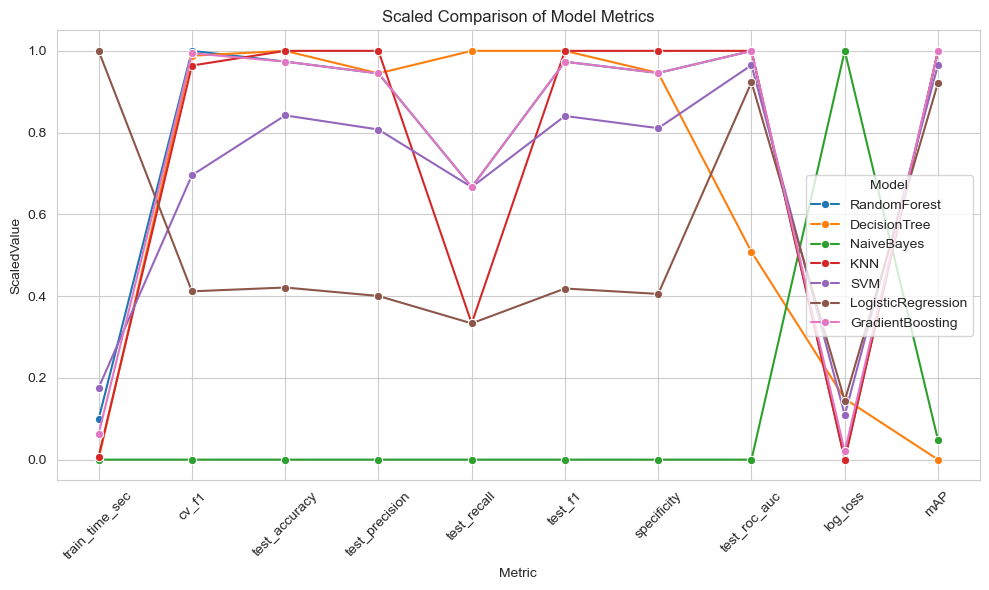

In [18]:
# ---------------------------------------------------------------------
# Section 6 Model Evaluations
# ---------------------------------------------------------------------
log_and_print("SECTION 6: MODEL COMPARISON", main_logger, level='info')

df_results = pd.DataFrame.from_dict(results, orient='index').reset_index()
df_results.rename(columns={'index': 'Model'}, inplace=True)

# Convert to Markdown table
ordered_cols = [
    'Model',
    'best_params',
    'train_time_sec',
    'cv_f1',
    'test_accuracy',
    'test_precision',
    'test_recall',
    'test_f1',
    'specificity',
    'test_roc_auc',
    'log_loss',
    'mAP',
    'confusion_matrix'
]

df_results = df_results[ordered_cols]

# Comparison table of model metrics:
metrics_markdown = df_results.to_markdown(index=False)
log_and_print("\nEvaluation of Model Metrics:\n", main_logger, level='info')
log_and_print(f"\n{metrics_markdown}", main_logger, level='info')

# Next: Create a line graph of each model with a scaled representation of numeric metrics
numeric_metrics = [
    'train_time_sec',
    'cv_f1',
    'test_accuracy',
    'test_precision',
    'test_recall',
    'test_f1',
    'specificity',
    'test_roc_auc',
    'log_loss',
    'mAP'
]

for col in numeric_metrics:
    df_results[col] = pd.to_numeric(df_results[col], errors='coerce')

df_plot = df_results.fillna(0).copy()

from sklearn.preprocessing import minmax_scale

for col in numeric_metrics:
    df_plot[col] = minmax_scale(df_plot[col])

df_melt = df_plot.melt(
    id_vars='Model',
    value_vars=numeric_metrics,
    var_name='Metric',
    value_name='ScaledValue'
)

plt.figure(figsize=(10,6))
sns.lineplot(data=df_melt, x='Metric', y='ScaledValue', hue='Model', marker='o')
plt.title("Scaled Comparison of Model Metrics")
plt.xticks(rotation=45)
plt.tight_layout()

scaled_plot_path = os.path.join(PLOTS_FOLDER, "model_metrics_scaled_line.png")
plt.savefig(scaled_plot_path, dpi=300)
log_and_print(f"Scaled metric line chart saved to {scaled_plot_path}", main_logger, level='info')
plt.show()

## Section 7 The Best Performing Model

Based on the metrics table, the **KNN** is the best-performing model.
1. Test F1 Score
    - KNN has an F1 of approximately 0.9994, effectively tied with the top contenders (e.g., DecisionTree at 0.999388).
2. ROC AUC, Log Loss, and mAP
    - KNN shows test_roc_auc = 0.999999, log_loss = 0.00168, and mAP = 1.0000, all of which are better (or at least as good as) other models with similarly high F1 scores.
    - For example, DecisionTree has a higher F1 (0.999388 vs. 0.999387) by a negligible margin, but a much higher log_loss (0.0331) and lower ROC AUC (0.99816).
3. Specificity
    - KNN's specificity is 1.0000, which indicates it perfectly classified the sample's negative (non-botnet) class.

Although models like DecisionTree, RandomForest, and GradientBoosting also achieve near‑perfect metrics, KNN is slightly with superior ROC AUC, log_loss, and specificity while retaining a ~0.9994 F1 score.

Considering the combination of F1, AUC, log loss, and mAP—KNN is the top performer and will be used to test the other subsets in the CTU-13 dataset.

In [22]:
# ---------------------------------------------------------------------
# SECTION 7: EVALUATE KNN ON MULTIPLE DATASETS
# ---------------------------------------------------------------------
import os
import pandas as pd
import time
import math
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc,
    log_loss, average_precision_score
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

def load_and_prepare_data(
    file_path,
    main_logger=None,
    drop_background=True,
    drop_cols=('sTos','dTos','StartTime'),
    label_col='Label'
):
    """
    Loads a CSV, performs the essential cleaning & feature engineering
    from Sections 2 & 3.

    If 'Label' is present and drop_background=True, removes rows with 'Background'.
    Then creates a 'Botnet' column, drops 'Label', etc.
    Returns (df_local, X_local, y_local).
    """
    if main_logger:
        log_and_print(f"\nLoading dataset from {file_path}...", main_logger, level='info')
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Cannot find file: {file_path}")

    df_local = pd.read_csv(file_path)

    # Possibly remove 'Background' rows
    if label_col in df_local.columns and drop_background:
        df_local = df_local[~df_local[label_col].str.contains('Background', case=False, na=False)]
        df_local['Botnet'] = df_local[label_col].apply(lambda x: 1 if 'botnet' in str(x).lower() else 0)
        df_local.drop(columns=[label_col], inplace=True, errors='ignore')
    else:
        if main_logger:
            log_and_print(
                "WARNING: No 'Label' column found or not dropping 'Background'. Adjust logic as needed.",
                main_logger,
                level='warning'
            )

    # Drop sTos, dTos, StartTime if present
    for c in drop_cols:
        if c in df_local.columns:
            df_local.drop(columns=[c], inplace=True, errors='ignore')

    # Safe division
    def safe_divide(num, denom):
        return num / denom if denom != 0 else 0

    # Create BytesPerSecond & PktsPerSecond
    if all(col in df_local.columns for col in ['TotBytes','Dur']):
        df_local['BytesPerSecond'] = df_local.apply(
            lambda r: safe_divide(r['TotBytes'], r['Dur']), axis=1
        )
    if all(col in df_local.columns for col in ['TotPkts','Dur']):
        df_local['PktsPerSecond'] = df_local.apply(
            lambda r: safe_divide(r['TotPkts'], r['Dur']), axis=1
        )

    # Address entropy
    def address_entropy(addr):
        addr_str = str(addr)
        c_count = Counter(addr_str)
        total_chars = len(addr_str)
        if total_chars < 2:
            return 0
        e_value = 0
        for char_count in c_count.values():
            p = char_count / total_chars
            e_value -= p * math.log2(p)
        return e_value

    if 'SrcAddr' in df_local.columns:
        df_local['SrcAddrEntropy'] = df_local['SrcAddr'].apply(address_entropy)
    if 'DstAddr' in df_local.columns:
        df_local['DstAddrEntropy'] = df_local['DstAddr'].apply(address_entropy)

    # Convert ports to range categories
    def get_port_range(x):
        try:
            port = int(x)
        except (ValueError, TypeError):
            return 'Unknown'
        if 0 <= port <= 1023:
            return 'WellKnown'
        elif 1024 <= port <= 49151:
            return 'Registered'
        elif 49152 <= port <= 65535:
            return 'Ephemeral'
        else:
            return 'Unknown'

    if 'Sport' in df_local.columns:
        df_local['SportRange'] = df_local['Sport'].apply(get_port_range)
        df_local.drop(columns=['Sport'], inplace=True, errors='ignore')
    if 'Dport' in df_local.columns:
        df_local['DportRange'] = df_local['Dport'].apply(get_port_range)
        df_local.drop(columns=['Dport'], inplace=True, errors='ignore')

    main_features = [
        'Dur','Proto','Dir','State','SrcAddr','DstAddr',
        'SportRange','DportRange','TotPkts','TotBytes','SrcBytes',
        'BytesPerSecond','PktsPerSecond','SrcAddrEntropy','DstAddrEntropy','Botnet'
    ]
    df_local = df_local[[c for c in main_features if c in df_local.columns]]

    # Separate X, y
    if 'Botnet' in df_local.columns:
        y_local = df_local['Botnet']
        X_local = df_local.drop('Botnet', axis=1)
    else:
        raise ValueError("No 'Botnet' column found. Adjust logic or check data.")

    # Drop IP columns
    for ipc in ['SrcAddr','DstAddr']:
        if ipc in X_local.columns:
            X_local.drop(columns=[ipc], inplace=True, errors='ignore')

    # Label-encode object columns
    cat_cols = ['Proto','Dir','State','SportRange','DportRange']
    for cat in cat_cols:
        if cat in X_local.columns and X_local[cat].dtype == 'object':
            X_local[cat] = X_local[cat].astype('category').cat.codes

    return df_local, X_local, y_local

# Section 7 Execution
log_and_print("\n\nSECTION 7: EVALUATE KNN ON MULTIPLE DATASETS\n", main_logger, level='info')

# A list of additional CSV data paths (as strings!)
file_paths = [
    os.path.join(DATA_FOLDER, '1-Neris-20110810.binetflow.csv'),
    os.path.join(DATA_FOLDER, '2-Neris-20110811.binetflow.csv'),
    os.path.join(DATA_FOLDER, '3-Rbot-20110812.binetflow.csv'),
    os.path.join(DATA_FOLDER, '4-Rbot-20110815.binetflow.csv'),
    os.path.join(DATA_FOLDER, '5-Virut-20110815-2.binetflow.csv'),
    os.path.join(DATA_FOLDER, '6-Menti-20110816.binetflow.csv'),
    os.path.join(DATA_FOLDER, '7-Sogou-20110816-2.binetflow.csv'),
    os.path.join(DATA_FOLDER, '8-Murlo-20110816-3.binetflow.csv'),
    os.path.join(DATA_FOLDER, '9-Neris-20110817.binetflow.csv'),
    os.path.join(DATA_FOLDER, '10-Rbot-20110818.binetflow.csv'),
    os.path.join(DATA_FOLDER, '11-Rbot-20110818-2.binetflow.csv'),
    os.path.join(DATA_FOLDER, '12-NsisAy-20110819.binetflow.csv'),
    os.path.join(DATA_FOLDER, '13-Virut-20110815-3.binetflow.csv')
]

# Optionally re-check the original dataset:
# file_paths.append(os.path.join(DATA_FOLDER, '11-Rbot-20110818-2.binetflow.csv'))

knn_results = []

# Hardcode the best KNN hyperparams found earlier
best_knn_params = {
    'n_neighbors': 5,
    'weights': 'distance'
}

for fp in file_paths:
    # Ensure 'fp' is a string
    if not isinstance(fp, str):
        log_and_print(
            f"WARNING: file_paths entry not a string! Type={type(fp)}, Value={fp}",
            main_logger, level='warning'
        )
        continue

    if not os.path.exists(fp):
        log_and_print(f"WARNING: File not found: {fp}", main_logger, level='warning')
        continue

    # 1) Load & prepare data
    df_local, X_local, y_local = load_and_prepare_data(fp, main_logger)

    # 2) Split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_local, y_local,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y_local
    )

    # 3) Scale
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_te_scaled = scaler.transform(X_te)

    # 4) Train KNN
    knn_model = KNeighborsClassifier(**best_knn_params)
    start_time = time.time()
    knn_model.fit(X_tr_scaled, y_tr)
    train_time = time.time() - start_time

    # 5) Evaluate
    y_pred = knn_model.predict(X_te_scaled)
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred)
    rec = recall_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)

    has_proba = hasattr(knn_model, "predict_proba")
    ll_val, map_val, roc_auc_val = None, None, None
    if has_proba:
        y_prob = knn_model.predict_proba(X_te_scaled)[:,1]
        try:
            ll_val = log_loss(y_te, y_prob)
        except ValueError:
            ll_val = None
        map_val = average_precision_score(y_te, y_prob)
        fpr, tpr, _ = roc_curve(y_te, y_prob)
        roc_auc_val = auc(fpr, tpr)

    cm = confusion_matrix(y_te, y_pred)
    tn, fp_, fn, tp = cm.ravel()
    specificity_val = tn / (tn + fp_) if (tn + fp_) else 0.0

    # Classification report
    clf_rep = classification_report(y_te, y_pred)
    main_logger.info(
        f"\nFile: {os.path.basename(fp)}\n"
        f"Classification Report:\n{clf_rep}"
    )

    knn_results.append({
        'Dataset': os.path.basename(fp),
        'TrainTimeSec': train_time,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'Specificity': specificity_val,
        'LogLoss': ll_val,
        'mAP': map_val,
        'ROC_AUC': roc_auc_val,
        'ConfusionMatrix': cm
    })

# Produce summary table
if knn_results:
    results_df = pd.DataFrame(knn_results)
    # Convert confusion matrix to string for nicer table display
    results_df['ConfusionMatrix'] = results_df['ConfusionMatrix'].apply(
        lambda c: str(c).replace('\n',' ')
    )

    table_markdown = results_df.to_markdown(index=False)
    log_and_print("\nKNN Evaluation Results Across Multiple Datasets:\n", main_logger, level='info')
    log_and_print(f"\n{table_markdown}", main_logger, level='info')
else:
    log_and_print("No datasets were evaluated in Section 7 (file_paths empty or invalid).", main_logger, level='warning')



SECTION 7: EVALUATE KNN ON MULTIPLE DATASETS


Loading dataset from data/1-Neris-20110810.binetflow.csv...

Loading dataset from data/2-Neris-20110811.binetflow.csv...

Loading dataset from data/3-Rbot-20110812.binetflow.csv...

Loading dataset from data/4-Rbot-20110815.binetflow.csv...

Loading dataset from data/5-Virut-20110815-2.binetflow.csv...

Loading dataset from data/6-Menti-20110816.binetflow.csv...

Loading dataset from data/7-Sogou-20110816-2.binetflow.csv...

Loading dataset from data/8-Murlo-20110816-3.binetflow.csv...

Loading dataset from data/9-Neris-20110817.binetflow.csv...

Loading dataset from data/10-Rbot-20110818.binetflow.csv...

Loading dataset from data/11-Rbot-20110818-2.binetflow.csv...

Loading dataset from data/12-NsisAy-20110819.binetflow.csv...

Loading dataset from data/13-Virut-20110815-3.binetflow.csv...

KNN Evaluation Results Across Multiple Datasets:


| Dataset                           |   TrainTimeSec |   Accuracy |   Precision |   Recall |    